<a href="https://colab.research.google.com/github/rahulkulk/MLOps-Labs/blob/main/Rahul_Lab6_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Pipeline Instead of Manual Scaling
# - Replaced manual StandardScaler() with a Pipeline (Scaler → Model)
# - Prevents data leakage during feature selection
# - Ensures consistent scaling across all methods

# 2. Added Cross-Validation (CV)
# - Added 5-fold CV accuracy using cross_val_score()
# - Makes feature selection results more stable and reliable
# - Avoids overfitting to a single train/test split

# 3. Added Training & Inference Time Metrics
# - Measured training time and prediction latency
# - Shows efficiency gains from using fewer features
# - Helps compare feature subsets beyond just accuracy

In [34]:
# Imports

import pandas as pd
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
!mkdir data

In [35]:
# Load the dataset
df = pd.read_csv('./data/breast_cancer_data.csv')

# Print datatypes
print(df.dtypes)

# Describe columns
df.describe(include='all')

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.037183e+07,NaN,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,NaN,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,NaN,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,NaN,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,NaN,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN


In [36]:
# Preview the dataset
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [37]:
# Check if there are null values in any of the columns. You will see `Unnamed: 32` has a lot.
df.isna().sum()

,0
id,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0


In [38]:
# Remove Unnamed: 32 and id columns
columns_to_remove = ['Unnamed: 32', 'id']
df.drop(columns_to_remove, axis=1, inplace=True)

# Check that the columns are indeed dropped
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [39]:
# Integer encode the target variable, diagnosis
df["diagnosis_int"] = (df["diagnosis"] == 'M').astype('int')

# Drop the previous string column
df.drop(['diagnosis'], axis=1, inplace=True)

# Check the new column
df.head()


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_int
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [41]:
# Split feature and target vectors
X = df.drop("diagnosis_int", axis = 1)
Y = df["diagnosis_int"]

In [42]:
def fit_model():
    '''Use a RandomForestClassifier for this problem.
       CHANGE #2: Return a Pipeline that includes StandardScaler + RandomForest.
    '''

    # define the pipeline to use: scaling + model
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(criterion='entropy', random_state=47))
    ])

    return model

In [43]:
def calculate_metrics(model, X_test_scaled, Y_test):
    '''Get model evaluation metrics on the test set.
       CHANGE #3: also measure inference time.

       Note: X_test_scaled is now just X_test (unscaled); the pipeline handles scaling.
    '''

    # Measure inference (prediction) time
    start_inf = time.time()
    y_predict_r = model.predict(X_test_scaled)
    inference_time = time.time() - start_inf

    # Calculate evaluation metrics for assessing performance of the model.
    acc = accuracy_score(Y_test, y_predict_r)
    roc = roc_auc_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r)
    rec = recall_score(Y_test, y_predict_r)
    f1 = f1_score(Y_test, y_predict_r)

    # RETURN inference time as well
    return acc, roc, prec, rec, f1, inference_time


In [44]:
def train_and_get_metrics(X, Y):
    '''Train a Random Forest Classifier and get evaluation metrics.
       CHANGE #1: Add cross-validation.
       CHANGE #2: Use Pipeline (scaling inside).
       CHANGE #3: Measure training time as well.
    '''

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size = 0.2, stratify=Y, random_state = 123
    )

    # Get the pipeline (scaler + model)
    model = fit_model()

    # Measure training time
    start_train = time.time()
    model.fit(X_train, Y_train)
    train_time = time.time() - start_train

    # Make predictions on test dataset and calculate metrics and inference time.
    acc, roc, prec, rec, f1, inference_time = calculate_metrics(model, X_test, Y_test)

    # 5-fold cross-validation accuracy on the same feature set
    cv_scores = cross_val_score(model, X, Y, cv=5)
    cv_acc = cv_scores.mean()

    # Also return feature count here (X.shape[1]) for convenience
    return acc, roc, prec, rec, f1, X.shape[1], train_time, inference_time, cv_acc


In [45]:
def evaluate_model_on_features(X, Y):
    '''Train model and display evaluation metrics.
       CHANGE #1 & #3: Include CV accuracy, train time, and inference time in the output.
    '''

    # Train the model, predict values and get metrics
    acc, roc, prec, rec, f1, feat_count, train_time, inf_time, cv_acc = train_and_get_metrics(X, Y)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame(
        [[acc, roc, prec, rec, f1, feat_count, train_time, inf_time, cv_acc]],
        columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score",
                 'Feature Count', 'Train Time (s)', 'Inference Time (s)', 'CV Accuracy']
    )

    return display_df


In [46]:
# Calculate evaluation metrics
all_features_eval_df = evaluate_model_on_features(X, Y)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
results = all_features_eval_df

# Check the metrics
results.head()


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Train Time (s),Inference Time (s),CV Accuracy
All features,0.964912,0.967262,0.931818,0.97619,0.953488,30,1.166293,0.06107,0.957833


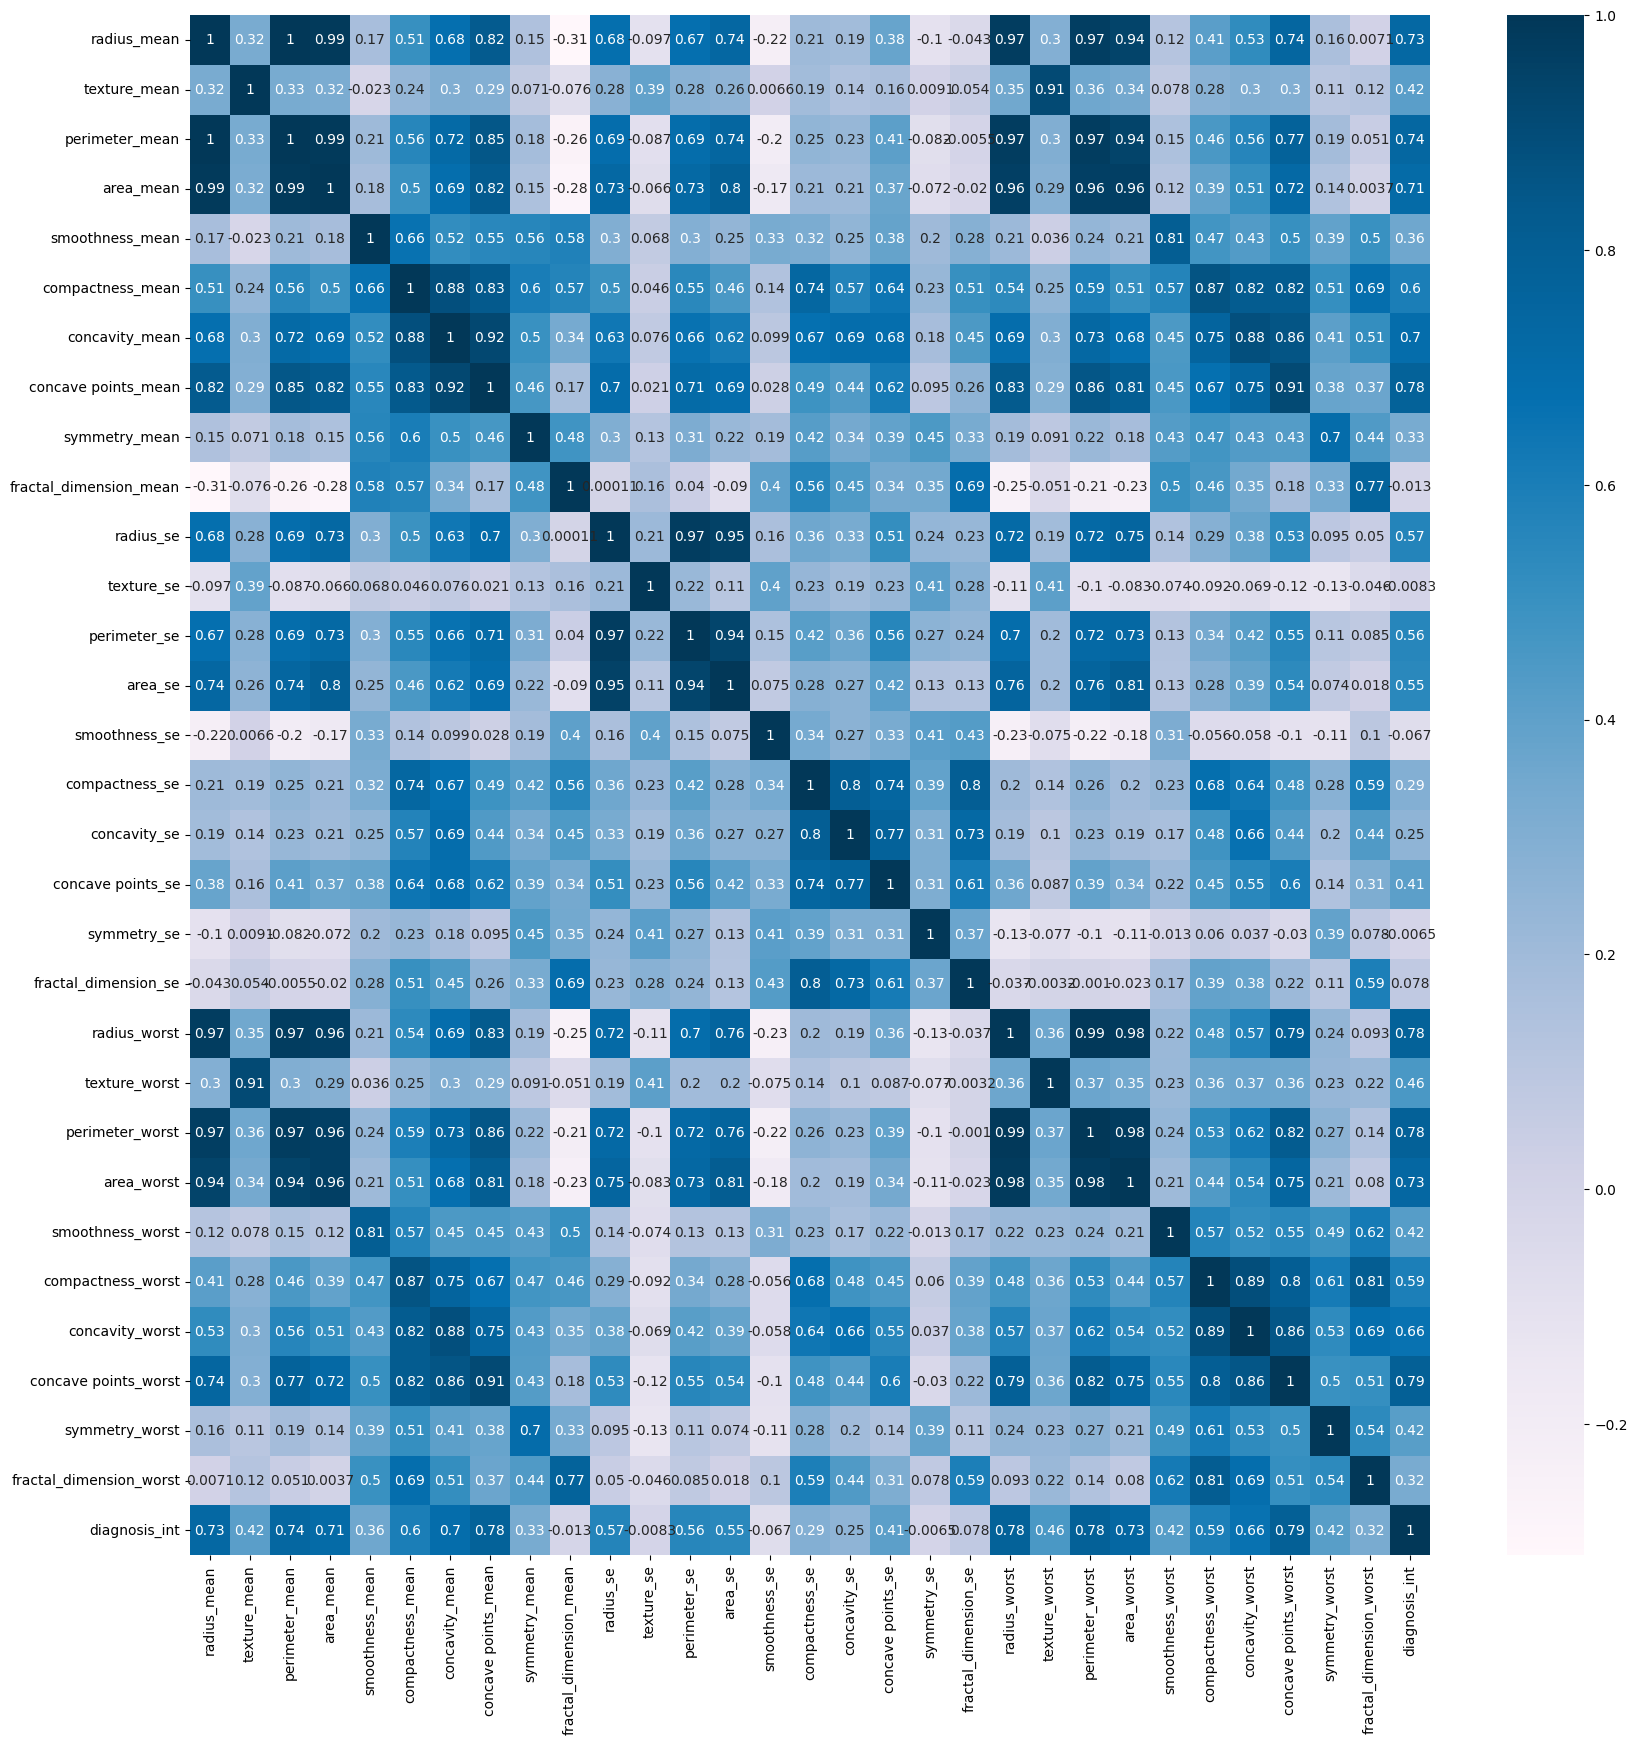

In [47]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate correlation matrix
cor = df.corr()

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()


In [49]:
# Get the absolute value of the correlation
cor_target = abs(cor["diagnosis_int"])

# Select highly correlated features (thresold = 0.2)
relevant_features = cor_target[cor_target>0.2]

# Collect the names of the features
names = [index for index, value in relevant_features.items()]

# Drop the target variable from the results
names.remove('diagnosis_int')

# Display the results
print(names)


['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [50]:
# Evaluate the model with new features
strong_features_eval_df = evaluate_model_on_features(df[names], Y)
strong_features_eval_df.index = ['Strong features']

# Append to results and display
# CHANGE: DataFrame.append is removed in pandas 2.0; use pd.concat instead.
results = pd.concat([results, strong_features_eval_df])
results.head()


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Train Time (s),Inference Time (s),CV Accuracy
All features,0.964912,0.967262,0.931818,0.97619,0.953488,30,1.166293,0.061070,0.957833
Strong features,0.973684,0.974206,0.953488,0.97619,0.964706,25,0.932331,0.017954,0.963111


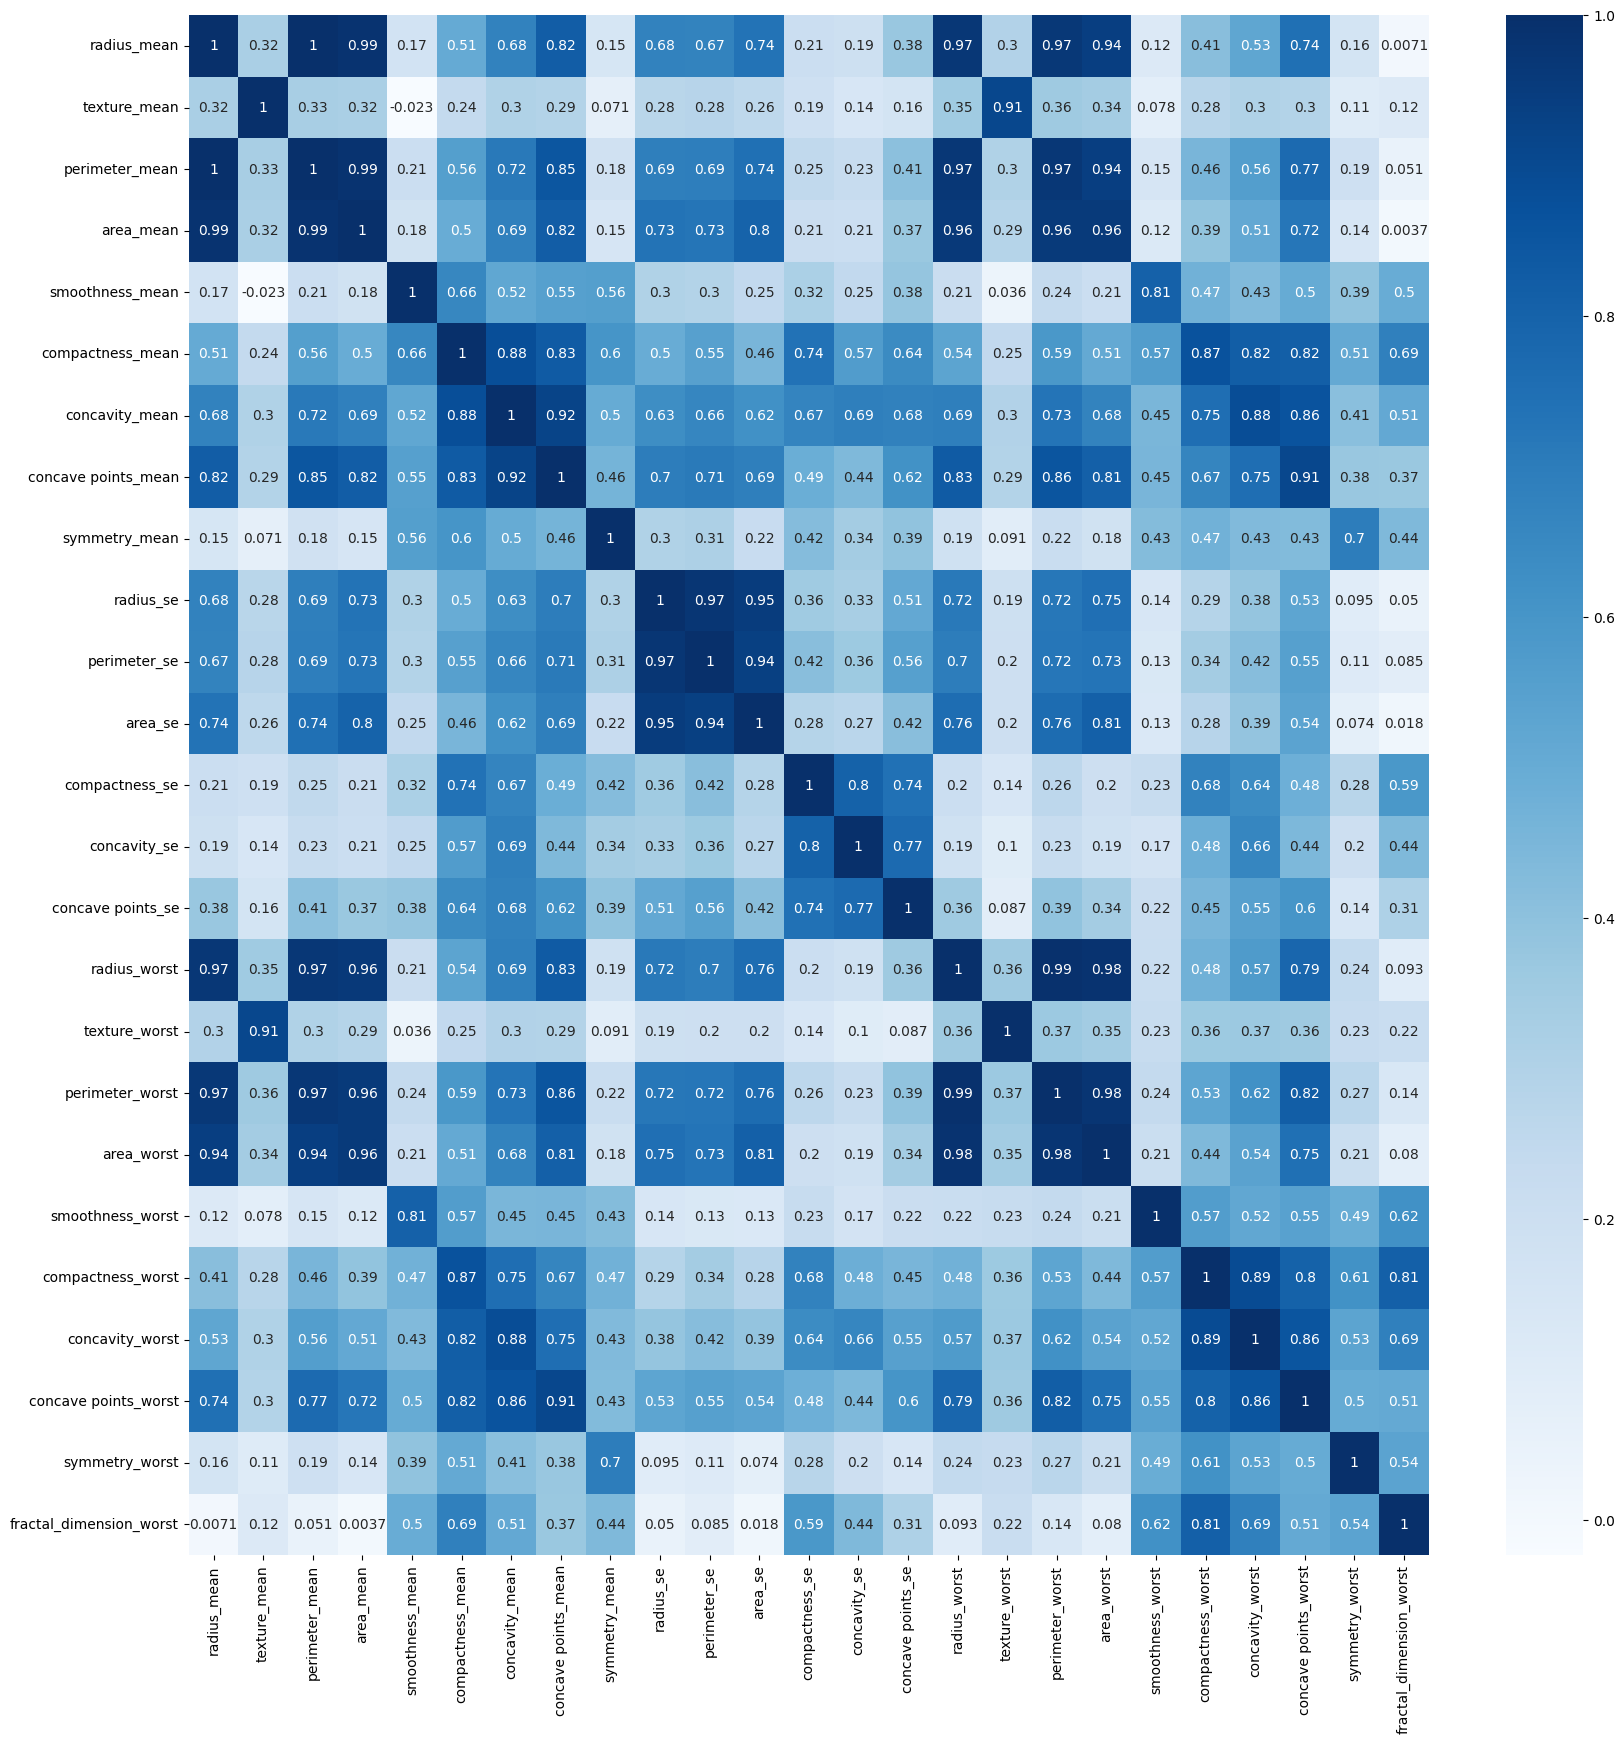

In [51]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate the correlation matrix for target relevant features that you previously determined
new_corr = df[names].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()


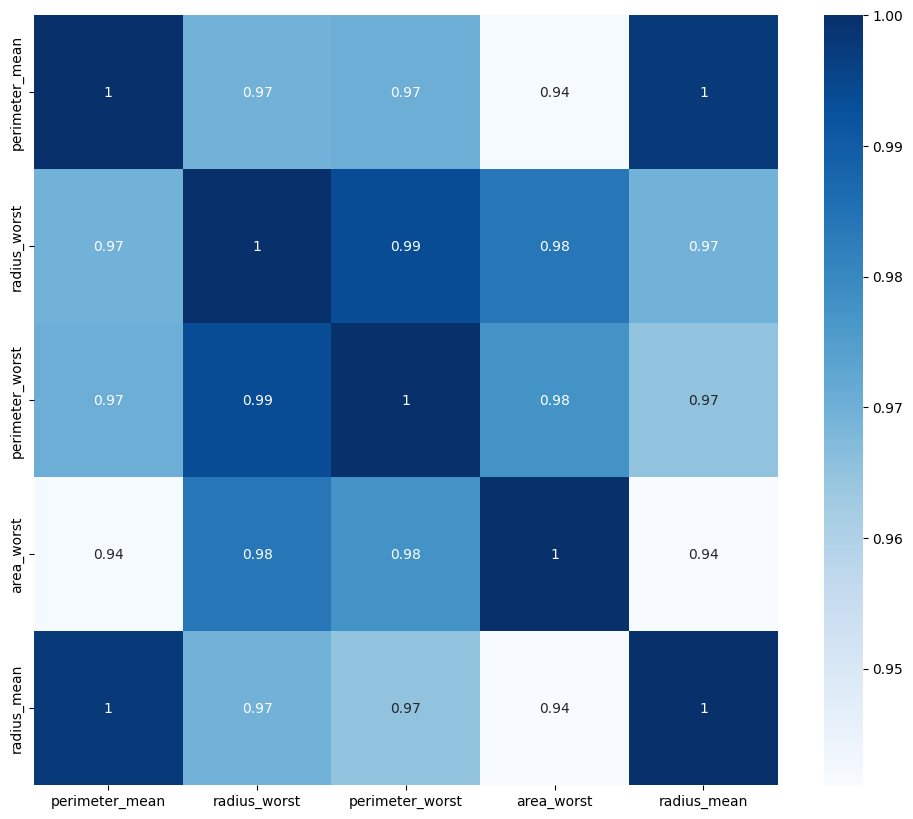

In [52]:
# Set figure size
plt.figure(figsize=(12,10))

# Select a subset of features
new_corr = df[['perimeter_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'radius_mean']].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()


In [53]:
# Remove the features with high correlation to other features
subset_feature_corr_names = [x for x in names if x not in ['radius_worst', 'perimeter_worst', 'area_worst']]

# Calculate and check evaluation metrics
subset_feature_eval_df = evaluate_model_on_features(df[subset_feature_corr_names], Y)
subset_feature_eval_df.index = ['Subset features']

# Append to results and display
results = pd.concat([results, subset_feature_eval_df])
results.head(n=10)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Train Time (s),Inference Time (s),CV Accuracy
All features,0.964912,0.967262,0.931818,0.97619,0.953488,30,1.166293,0.061070,0.957833
Strong features,0.973684,0.974206,0.953488,0.97619,0.964706,25,0.932331,0.017954,0.963111
Subset features,0.973684,0.974206,0.953488,0.97619,0.964706,22,0.432431,0.016212,0.956063


In [58]:
def univariate_selection():

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size = 0.2, stratify=Y, random_state = 123
    )

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    # NOTE: This scaling is just for feature scoring, not for model training (the pipeline handles training-time scaling).
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # Use SelectKBest to select top 20 features based on f-test
    selector = SelectKBest(f_classif, k=20)

    # Fit to scaled data, then transform it
    X_new = selector.fit_transform(X_train_scaled, Y_train)

    # Print the results
    feature_idx = selector.get_support()
    for name, included in zip(df.drop("diagnosis_int", axis=1).columns, feature_idx):
        print("%s: %s" % (name, included))

    # Drop the target variable
    feature_names = df.drop("diagnosis_int", axis=1).columns[feature_idx]

    return feature_names


In [59]:
univariate_feature_names = univariate_selection()

# Calculate and check model metrics
univariate_eval_df = evaluate_model_on_features(df[univariate_feature_names], Y)
univariate_eval_df.index = ['F-test']

# Append to results and display
results = pd.concat([results, univariate_eval_df])
results.head(n=10)


radius_mean: True
texture_mean: True
perimeter_mean: True
area_mean: True
smoothness_mean: False
compactness_mean: True
concavity_mean: True
concave points_mean: True
symmetry_mean: False
fractal_dimension_mean: False
radius_se: True
texture_se: False
perimeter_se: True
area_se: True
smoothness_se: False
compactness_se: False
concavity_se: False
concave points_se: True
symmetry_se: False
fractal_dimension_se: False
radius_worst: True
texture_worst: True
perimeter_worst: True
area_worst: True
smoothness_worst: True
compactness_worst: True
concavity_worst: True
concave points_worst: True
symmetry_worst: True
fractal_dimension_worst: False


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Train Time (s),Inference Time (s),CV Accuracy
All features,0.964912,0.967262,0.931818,0.97619,0.953488,30,1.166293,0.061070,0.957833
Strong features,0.973684,0.974206,0.953488,0.97619,0.964706,25,0.932331,0.017954,0.963111
Subset features,0.973684,0.974206,0.953488,0.97619,0.964706,22,0.432431,0.016212,0.956063
F-test,0.973684,0.974206,0.953488,0.97619,0.964706,20,0.407261,0.017842,0.966636


In [62]:
def run_rfe():

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size = 0.2, stratify=Y, random_state = 123
    )

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    # Again, this scaling is only for computing the RFE feature subset.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the model
    model = RandomForestClassifier(criterion='entropy', random_state=47)

    # Wrap RFE around the model
    rfe = RFE(model, n_features_to_select=20)

    # Fit RFE
    rfe = rfe.fit(X_train_scaled, Y_train)
    feature_names = df.drop("diagnosis_int",axis = 1 ).columns[rfe.get_support()]

    return feature_names


In [63]:
rfe_feature_names = run_rfe()

# Calculate and check model metrics
rfe_eval_df = evaluate_model_on_features(df[rfe_feature_names], Y)
rfe_eval_df.index = ['RFE']

# Append to results and display
results = pd.concat([results, rfe_eval_df])
results.head(n=10)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Train Time (s),Inference Time (s),CV Accuracy
All features,0.964912,0.967262,0.931818,0.97619,0.953488,30,1.166293,0.061070,0.957833
Strong features,0.973684,0.974206,0.953488,0.97619,0.964706,25,0.932331,0.017954,0.963111
Subset features,0.973684,0.974206,0.953488,0.97619,0.964706,22,0.432431,0.016212,0.956063
F-test,0.973684,0.974206,0.953488,0.97619,0.964706,20,0.407261,0.017842,0.966636
RFE,0.964912,0.967262,0.931818,0.97619,0.953488,20,0.418098,0.017863,0.968359


In [64]:
def feature_importances_from_tree_based_model_():

    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size = 0.2, stratify=Y, random_state = 123
    )

    # Define the model to use
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestClassifier()
    model = model.fit(X_train_scaled, Y_train)

    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()

    return model


In [67]:
def select_features_from_model(model):

    model = SelectFromModel(model, prefit=True, threshold=0.013)
    feature_idx = model.get_support()
    feature_names = df.drop("diagnosis_int",axis = 1 ).columns[feature_idx]

    return feature_names


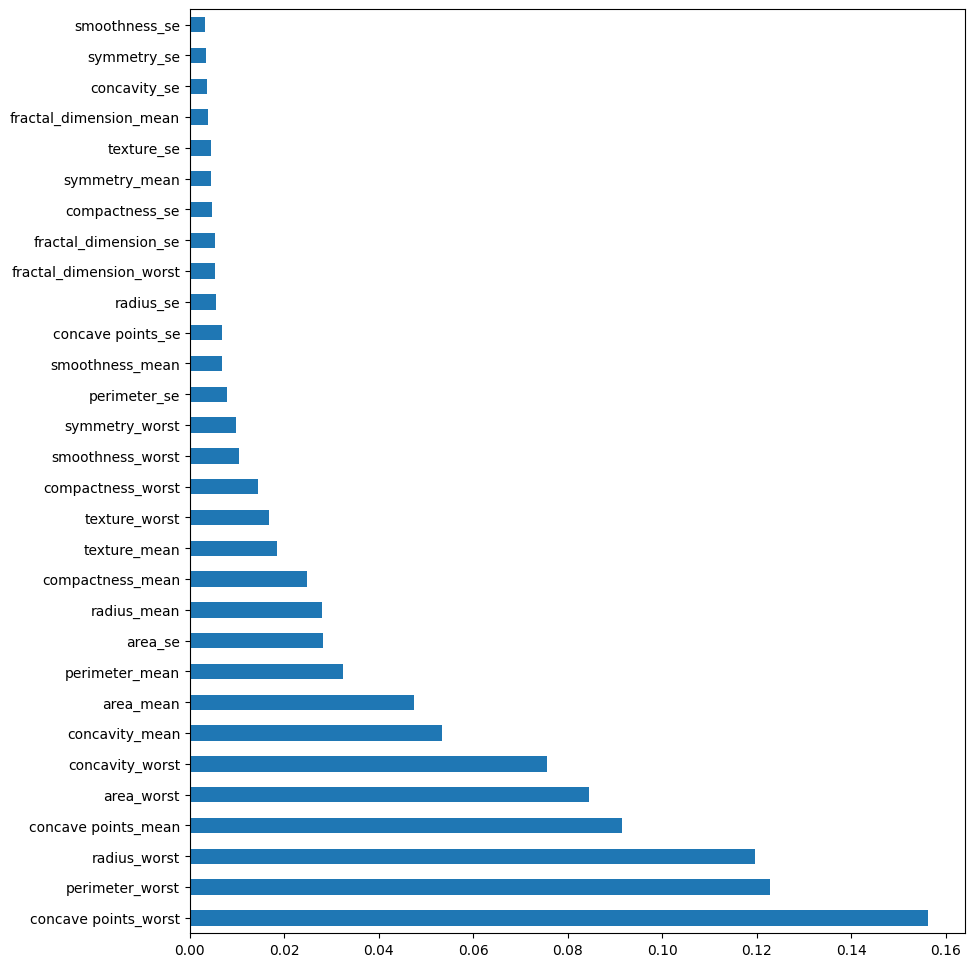

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Train Time (s),Inference Time (s),CV Accuracy
All features,0.964912,0.967262,0.931818,0.97619,0.953488,30,1.166293,0.061070,0.957833
Strong features,0.973684,0.974206,0.953488,0.97619,0.964706,25,0.932331,0.017954,0.963111
Subset features,0.973684,0.974206,0.953488,0.97619,0.964706,22,0.432431,0.016212,0.956063
F-test,0.973684,0.974206,0.953488,0.97619,0.964706,20,0.407261,0.017842,0.966636
RFE,0.964912,0.967262,0.931818,0.97619,0.953488,20,0.418098,0.017863,0.968359
Feature Importance,0.964912,0.967262,0.931818,0.97619,0.953488,15,0.386216,0.017601,0.966620


In [68]:
model = feature_importances_from_tree_based_model_()
feature_imp_feature_names = select_features_from_model(model)

# Calculate and check model metrics
feat_imp_eval_df = evaluate_model_on_features(df[feature_imp_feature_names], Y)
feat_imp_eval_df.index = ['Feature Importance']

# Append to results and display
results = pd.concat([results, feat_imp_eval_df])
results.head(n=10)


In [70]:
def run_l1_regularization():

    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size = 0.2, stratify=Y, random_state = 123
    )

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Select L1 regulated features from LinearSVC output
    selection = SelectFromModel(LinearSVC(C=1, penalty='l1', dual=False))
    selection.fit(X_train_scaled, Y_train)

    feature_names = df.drop("diagnosis_int",axis = 1 ).columns[(selection.get_support())]

    return feature_names


In [71]:
l1reg_feature_names = run_l1_regularization()

# Calculate and check model metrics
l1reg_eval_df = evaluate_model_on_features(df[l1reg_feature_names], Y)
l1reg_eval_df.index = ['L1 Reg']

# Append to results and display
results = pd.concat([results, l1reg_eval_df])
results.head(n=10)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Train Time (s),Inference Time (s),CV Accuracy
All features,0.964912,0.967262,0.931818,0.976190,0.953488,30,1.166293,0.061070,0.957833
Strong features,0.973684,0.974206,0.953488,0.976190,0.964706,25,0.932331,0.017954,0.963111
Subset features,0.973684,0.974206,0.953488,0.976190,0.964706,22,0.432431,0.016212,0.956063
F-test,0.973684,0.974206,0.953488,0.976190,0.964706,20,0.407261,0.017842,0.966636
RFE,0.964912,0.967262,0.931818,0.976190,0.953488,20,0.418098,0.017863,0.968359
Feature Importance,0.964912,0.967262,0.931818,0.976190,0.953488,15,0.386216,0.017601,0.966620
L1 Reg,0.929825,0.929563,0.886364,0.928571,0.906977,18,0.830202,0.075648,0.959587


In [72]:
# Final results with all methods, now including:
# - Feature Count
# - Train Time
# - Inference Time
# - CV Accuracy
results

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Train Time (s),Inference Time (s),CV Accuracy
All features,0.964912,0.967262,0.931818,0.976190,0.953488,30,1.166293,0.061070,0.957833
Strong features,0.973684,0.974206,0.953488,0.976190,0.964706,25,0.932331,0.017954,0.963111
Subset features,0.973684,0.974206,0.953488,0.976190,0.964706,22,0.432431,0.016212,0.956063
F-test,0.973684,0.974206,0.953488,0.976190,0.964706,20,0.407261,0.017842,0.966636
RFE,0.964912,0.967262,0.931818,0.976190,0.953488,20,0.418098,0.017863,0.968359
Feature Importance,0.964912,0.967262,0.931818,0.976190,0.953488,15,0.386216,0.017601,0.966620
L1 Reg,0.929825,0.929563,0.886364,0.928571,0.906977,18,0.830202,0.075648,0.959587
